In [249]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math

In [251]:
def gaussian_distribution(x, std, mean):
    return (1/(std*math.sqrt(2*math.pi)))*math.exp((-1/2)*((x-mean)/std)**2)

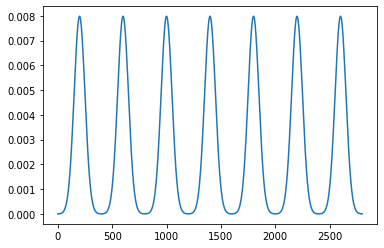

In [252]:
# Here we have assumed a wave will get over in 4 * std amount of time, since we assumed a wave
# will be over in 200 days we have considered 50 as std
gdist = [gaussian_distribution(i, 50, 200) for i in range(0, 400)]

gdist = np.concatenate((gdist, gdist, gdist, gdist, gdist, gdist, gdist))

plt.plot(gdist)
df = np.array(gdist)

(2250, 50, 1)
(2250,)


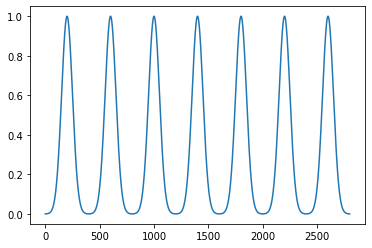

In [253]:
scaler = MinMaxScaler(feature_range=(0, 1))

scaled_data = scaler.fit_transform(df.reshape(-1, 1)) #reshape for (n, ) to (n, 1)

plt.plot(scaled_data)

look_back = 50
prediction_days = 500

x_train, y_train = [], []

for x in range(look_back, len(scaled_data) - prediction_days):
  x_train.append(scaled_data[x - look_back: x, 0])
  y_train.append(scaled_data[x, 0])
    
x_train, y_train = np.array(x_train), np.array(y_train)

x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))


print(x_train.shape)
print(y_train.shape)

In [254]:
model = Sequential()

model.add(LSTM(units = 50, return_sequences=True, input_shape = (x_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units = 50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units = 50))
model.add(Dropout(0.2))
model.add(Dense(units = 1))  #our predictions
model.compile(optimizer = 'adam', loss = 'mean_squared_error')

In [255]:
model.fit(x_train, y_train, epochs = 5, batch_size = 32)

Epoch 1/5
71/71 [==============================] - 24s 170ms/step - loss: 0.0245
Epoch 2/5
71/71 [==============================] - 13s 189ms/step - loss: 0.0042
Epoch 3/5
71/71 [==============================] - 11s 149ms/step - loss: 0.0025
Epoch 4/5
71/71 [==============================] - 10s 143ms/step - loss: 0.0022
Epoch 5/5
71/71 [==============================] - 10s 148ms/step - loss: 0.0023


In [256]:
last = x_train[len(scaled_data) - prediction_days - look_back - 1]
print(last.shape)

x_test = np.array([last])
ys = []
for i in range(0, prediction_days):
    ysi = model.predict(x_test)[0]
    ys.append(np.array([max(0, ysi[0])]))
    x_test = np.array([np.concatenate((last[1:], [ys[-1]]))])
    last = x_test[0]

(50, 1)


In [257]:
predicted_cases = scaler.inverse_transform(ys)
pred = np.concatenate((df[:len(scaled_data)-prediction_days], predicted_cases.reshape(-1,)))

(2250, 50, 1)


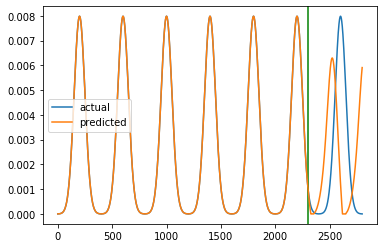

In [258]:
plt.figure()
plt.plot(df, label="actual")
plt.axvline(x = (400*7 - prediction_days), c='green')
plt.plot(pred, label="predicted")
plt.legend()

print(x_train.shape)

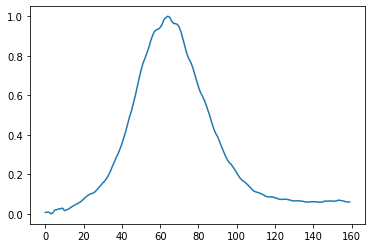

In [325]:
def smoothen(df, period):
    df_ma = df.copy()
    for i in range(period, len(df)):
        ma = 0
        for j in range(i - period + 1, i + 1):
            ma += df[j]
        df_ma[i] = ma / period
    return df_ma
df_ind = pd.read_csv('india.csv')['new_cases'].values
df_ind = df_ind[400:560]

df_ind = smoothen(df_ind, 10)

scaled_data_ind = scaler.fit_transform(df_ind.reshape(-1, 1))

plt.plot(scaled_data_ind)

In [326]:
extra_predictions = 40

last = scaled_data_ind[:look_back]
x_test = np.array([last])
ys = []
for i in range(0, len(scaled_data_ind) - look_back + extra_predictions):
    ysi = model.predict(x_test)[0]
    ys.append(np.array([max(0, ysi[0])]))
    x_test = np.array([np.concatenate((last[1:], [ys[-1]]))])
    last = x_test[0]
    
predicted_cases = scaler.inverse_transform(ys)
pred = np.concatenate((df_ind[:look_back], predicted_cases.reshape(-1,)))

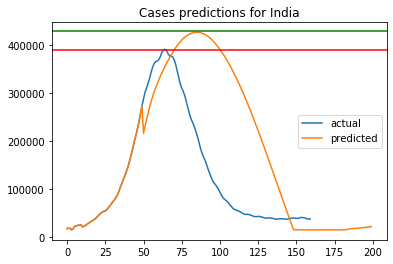

In [332]:
plt.figure()
plt.title("Cases predictions for India")
plt.plot(df_ind, label="actual")
plt.plot(pred, label="predicted")
plt.axhline(y=430000,c='green')
plt.axhline(y=390000,c='red')
plt.legend()

In [333]:
df = pd.read_csv("covid-data.csv")

df_is = smoothen(df[df.location == "Israel"]['new_cases'].dropna().values[650:750], 15)

scaled_data_is = scaler.fit_transform(df_is.reshape(-1, 1))

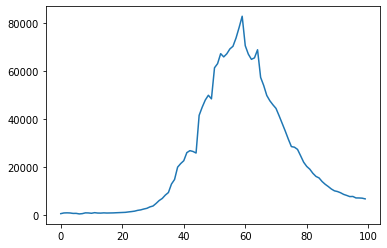

In [334]:
plt.plot(df_is)

In [335]:
extra_predictions = 40

last = scaled_data_is[:look_back]
x_test = np.array([last])
ys = []
for i in range(0, len(scaled_data_is) - look_back + extra_predictions):
    ysi = model.predict(x_test)[0]
    ys.append(np.array([max(0, ysi[0])]))
    x_test = np.array([np.concatenate((last[1:], [ys[-1]]))])
    last = x_test[0]
    
predicted_cases = scaler.inverse_transform(ys)
pred = np.concatenate((df_is[:look_back], predicted_cases.reshape(-1,)))

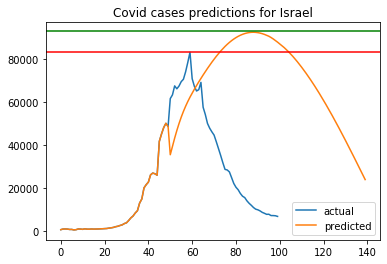

In [336]:
plt.figure()
plt.title("Covid cases predictions for Israel")
plt.plot(df_is, label="actual")
plt.plot(pred, label="predicted")
plt.axhline(y=93000, c='green')
plt.axhline(y=83000, c='red')
plt.legend()